In [1]:
import numpy as np
import math as math
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import csv
import cv2
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.integrate import quad
import sklearn
import codecs, json 
import scipy.io
import h5py

device=torch.device("cuda:0")

# Import topnet utilities
import sys
sys.path.insert(0, '/home/ephy/Projects/tda_convolution/src/')
import topnet
import importlib
importlib.reload(topnet)

<module 'topnet' from '/home/ephy/Projects/tda_convolution/src/topnet.py'>

In [2]:
colordict = {'NOL + NOL': '#1f77b4', 'KF + KOL': '#ff7f0e', 'KF + NOL': '#2ca02c',
             'CF + COL': '#d62728', 'CF + NOL': '#9467bd', 'KF + KF Pooled': '#593108',
             'NOL + NOL Pooled': '#9b9e37','KF + KF': "#7d70b5"}

In [3]:
datadir='/home/ephy/Projects/tda_convolution/data/original/SVHN/'
trainmat = scipy.io.loadmat(datadir+'train_32x32.mat')
testmat = scipy.io.loadmat(datadir+'test_32x32.mat')

In [4]:
# Resize to MNIST and change to grayscale
X=list()
for i in range(trainmat['X'].shape[3]):
    X.append(cv2.resize(trainmat['X'][...,i], (28,28)))
    
for i in range(testmat['X'].shape[3]):
    X.append(cv2.resize(testmat['X'][...,i], (28,28)))
    
# X=torch.tensor(np.dot(X[...,:3], [0.299, 0.587, 0.114]), dtype=torch.float32).view(-1,1,32,32)
X=np.dot((np.array(X)/255)[...,:3], [0.299, 0.587, 0.114])

In [5]:
train_y = np.array(trainmat['y']).flatten()
test_y = np.array(testmat['y']).flatten()
y=np.append(train_y,test_y)
classes=len(np.unique(y))
y[y==10]=0 # swtich coding of classes

### Classes are not ballanced in SVHN, so let's just make even samples

In [6]:
y_ballanced=list()
X_ballanced=list()

n = np.arange(np.min(np.histogram(np.array(y))[0]))
np.random.shuffle(n)
for i in range(classes):
    y_ballanced.append(y[y==(i)][n])
    X_ballanced.append(X[y==(i)][n])
    
X_ballanced = np.array(X_ballanced)
X_ballanced = X_ballanced.reshape(np.product(X_ballanced.shape[0:2]),X_ballanced.shape[2],X_ballanced.shape[3])
y_ballanced = np.array(y_ballanced)
y_ballanced = y_ballanced.reshape(np.product(y_ballanced.shape[0:2]))

In [26]:
train_X , test_X , train_y , test_y = train_test_split(X_ballanced , y_ballanced, 
                                                test_size = 0.2 ,
                                                random_state = 1)

In [34]:
classes=list(range(10))
train_X = torch.tensor(train_X,  dtype=torch.float32)
test_X = torch.tensor(test_X,  dtype=torch.float32)
train_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in train_y]), dtype=torch.float32)
test_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in test_y]), dtype=torch.float32)

## Load MNIST

In [9]:
REBUILD_DATA = False
datadir = '/home/ephy/Projects/tda_init_cnn/data/'

train = datasets.MNIST(datadir+"original/", train=True, download=False, 
                      transform= transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(datadir+"original/", train=False, download=False, 
                      transform= transforms.Compose([transforms.ToTensor()]))

In [10]:
mnist_train_X = torch.tensor([np.array(i[0]) for i in train])
mnist_test_X = torch.tensor([np.array(i[0]) for i in test])
mnist_train_y = [i[1] for i in train]
mnist_test_y = [i[1] for i in test]

In [11]:
classes=np.unique(mnist_train_y)
mnist_test_y = torch.tensor([np.array([int(n) for n in x==classes]) for x in mnist_test_y], dtype=torch.float32)
mnist_train_y = torch.tensor([np.array([int(n) for n in x==classes]) for x in mnist_train_y], dtype=torch.float32)

## Load USPS Digits

In [12]:
classes=list(range(10))
with h5py.File('/home/ephy/Projects/tda_convolution/data/original/USPS/usps.h5', 'r') as hf:
        usps_train_X = hf.get('train').get('data')[:]
        usps_train_y = hf.get('train').get('target')[:]
        usps_test_X = hf.get('test').get('data')[:]
        usps_test_y = hf.get('test').get('target')[:]
        
usps_train_X = torch.tensor(usps_train_X.reshape(-1,16,16), dtype=torch.float32)
usps_test_X = torch.tensor(usps_test_X.reshape(-1,16,16), dtype=torch.float32)
usps_train_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in usps_train_y]), dtype=torch.float32)
usps_test_y = torch.tensor(np.array([[int(n) for n in x==classes] for x in usps_test_y]), dtype=torch.float32)


In [13]:
X=list()
for i in range(mnist_train_X.shape[0]):
    X.append(cv2.resize(np.array(mnist_train_X[i][0]), (16,16)))
mnist_train_X_16x16 = torch.tensor(X, dtype=torch.float32)

## Cats and Dogs vs CIFAR Cats and DOgs

In [14]:
buildData=False
datadir = '/home/ephy/Projects/tda_convolution/data/original/CIFAR/cifar-10-batches-py/'
if buildData:
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    train_X = list()
    train_y = list()
    for batch in os.listdir(datadir):
        if 'data_batch' in batch:
            resp = unpickle(datadir+batch)
            for i, item in enumerate(resp[b'data'].reshape(-1,3,32,32)):
                train_X.append(np.moveaxis(item,0,-1)/255)
                train_y.append(resp[b'labels'][i])
    train_X = np.array(train_X)
    train_y = np.array(train_y)

    test_X = list()
    test_y = list()
    resp=unpickle(datadir+'test_batch')
    for i, item in enumerate(resp[b'data'].reshape(-1,3,32,32)):
        test_X.append(np.moveaxis(item,0,-1)/255)
        test_y.append(resp[b'labels'][i])

    test_X = np.array(test_X)
    test_y = np.array(test_y)

    # Go ahead and gray scale these
    test_X = np.dot(test_X[...,:3], [0.299, 0.587, 0.114])
    train_X = np.dot(train_X[...,:3], [0.299, 0.587, 0.114])

    nClasses=len(np.unique(train_y))
    test_y = np.array([np.eye(nClasses)[x] for x in test_y])
    train_y = np.array([np.eye(nClasses)[x] for x in train_y])
    
    np.save('../data/altered/CIFAR/train_X' , train_X)
    np.save('../data/altered/CIFAR/train_y' , train_y)
    np.save('../data/altered/CIFAR/test_X' , test_X)
    np.save('../data/altered/CIFAR/test_y' , test_y)
    
train_X=np.load('../data/altered/CIFAR/train_X.npy' )
train_y=np.load('../data/altered/CIFAR/train_y.npy' )
test_X=np.load('../data/altered/CIFAR/test_X.npy' )
test_y=np.load('../data/altered/CIFAR/test_y.npy' )
    
train_X = torch.tensor(train_X, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

cifar_train_cats_X = np.array(train_X)[np.all(np.array(train_y)==np.eye(10)[3], axis=1)]
cifar_train_dogs_X = np.array(train_X)[np.all(np.array(train_y)==np.eye(10)[5], axis=1)]
cifar_test_cats_X = np.array(test_X)[np.all(np.array(test_y)==np.eye(10)[3], axis=1)]
cifar_test_dogs_X = np.array(test_X)[np.all(np.array(test_y)==np.eye(10)[5], axis=1)]

cifar_cats_X = np.append(cifar_train_cats_X, cifar_test_cats_X,axis=0)
cifar_dogs_X = np.append(cifar_train_dogs_X, cifar_test_dogs_X,axis=0)

cifar_train_X = torch.tensor(np.append(cifar_cats_X, cifar_dogs_X,axis=0), dtype=torch.float32)
cifar_train_y = torch.tensor(np.append(np.tile(np.eye(2)[0],[6000,1]),np.tile(np.eye(2)[1],[6000,1]),axis=0), dtype=torch.float32)

shuff = np.arange(len(cifar_train_y))
np.random.shuffle(shuff)

cifar_train_X = cifar_train_X[shuff]
cifar_train_y = cifar_train_y[shuff]

In [15]:
REBUILD_DATA = False
datadir = '/home/ephy/Projects/tda_init_cnn/data/'
device = torch.device("cuda:0")

class DogsVSCats():
    IMG_SIZE = 32
    CATS = datadir + "original/kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = datadir + "original/kagglecatsanddogs_3367a/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 0}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])                  
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                            
                except Exception as e:
                    #print(str(e))
                    pass
                
        np.random.shuffle(self.training_data)
        np.save(datadir + "altered/catdog_training_data_32x32.npy", self.training_data)
        
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
training_data = np.load(datadir+"altered/catdog_training_data_32x32.npy", allow_pickle=True)

X = np.array([i[0] for i in training_data])
kaggle_cd_X = X/255.0
kaggle_cd_y = np.array([i[1] for i in training_data])
kaggle_cd_X = kaggle_cd_X.astype(np.float32)
kaggle_cd_y = kaggle_cd_y.astype(np.float32)

kaggle_cd_X = torch.tensor(kaggle_cd_X)
kaggle_cd_y = torch.tensor(kaggle_cd_y)

In [16]:
configs=dict()
config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,[('Klein',8,8,3,.35)]]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=2
config['imageDim']=(32,32)
config['test_X']=kaggle_cd_X
config['test_y']=kaggle_cd_y
config['train_y']=cifar_train_y
config['train_X']=cifar_train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='CIFAR -> KAGGLE'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + KOL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],[('Klein',8,8,3,None)]]
config['freeze_layers']=[True,True]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, None]
config['learning_rate']=1e-5
config['classes']=2
config['imageDim']=(32,32)
config['test_X']=kaggle_cd_X
config['test_y']=kaggle_cd_y
config['train_y']=cifar_train_y
config['train_X']=cifar_train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='CIFAR -> KAGGLE'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + KF'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],[('Klein',8,8,3,None)]]
config['freeze_layers']=[True,True]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,['F.max_pool2d',(2,2)]]
config['activations']=[None, None]
config['learning_rate']=1e-5
config['classes']=2
config['imageDim']=(32,32)
config['test_X']=kaggle_cd_X
config['test_y']=kaggle_cd_y
config['train_y']=cifar_train_y
config['train_X']=cifar_train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='CIFAR -> KAGGLE'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + KF Pooled'] = config

config = dict()
config['weights_config']=[None,None]
config['freeze_layers']=[False,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=['F.relu', 'F.relu']
config['learning_rate']=1e-5
config['classes']=2
config['imageDim']=(32,32)
config['test_X']=kaggle_cd_X
config['test_y']=kaggle_cd_y
config['train_y']=cifar_train_y
config['train_X']=cifar_train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='CIFAR -> KAGGLE'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL + NOL'] = config

config = dict()
config['weights_config']=[None,None]
config['freeze_layers']=[False,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=['F.relu', 'F.relu']
config['learning_rate']=1e-5
config['classes']=2
config['imageDim']=(32,32)
config['test_X']=kaggle_cd_X
config['test_y']=kaggle_cd_y
config['train_y']=cifar_train_y
config['train_X']=cifar_train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='CIFAR -> KAGGLE'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL + NOL Pooled'] = config

In [17]:
results = dict()
results['CIFAR -> KAGGLE'] = topnet.run_configs(configs, None)

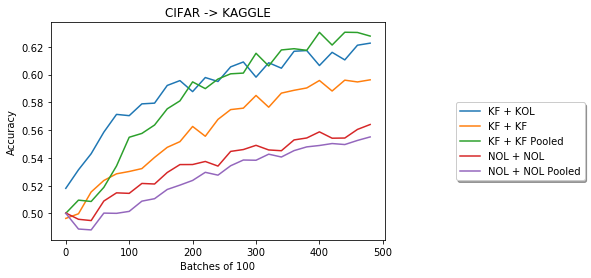

In [21]:
topnet.plot_results(results=results, dataset='CIFAR -> KAGGLE',item='accuracies')

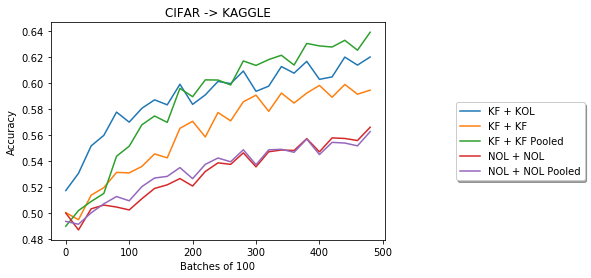

In [21]:
topnet.plot_results(results=results, dataset='CIFAR -> KAGGLE',item='accuracies')

In [18]:
for name, config in configs.items():
    config['train_X']=kaggle_cd_X
    config['train_y']=kaggle_cd_y
    config['test_y']=cifar_train_y
    config['test_X']=cifar_train_X
    config['dataset']='KAGGLE -> CIFAR'

In [19]:
results['KAGGLE -> CIFAR'] = topnet.run_configs(configs, None)

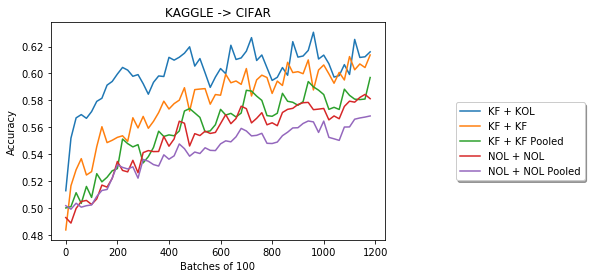

In [24]:
topnet.plot_results(results=results, dataset='KAGGLE -> CIFAR',item='accuracies')

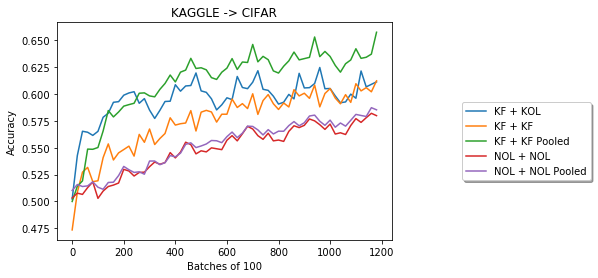

In [24]:
topnet.plot_results(results=results, dataset='KAGGLE -> CIFAR',item='accuracies')

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


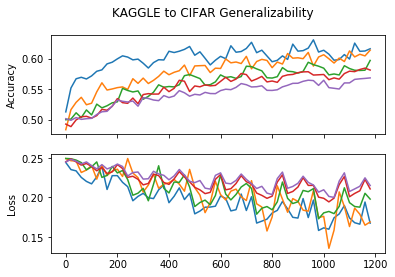

In [25]:
fig, axarr = plt.subplots(2, sharex=True)
fig.set()
fig.suptitle('KAGGLE to CIFAR Generalizability')
dataset='KAGGLE -> CIFAR'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], label=name)
for name, item in configuration.items():
    axarr[1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['loss'])
    
axarr[0].set(ylabel='Accuracy')
axarr[1].set(ylabel='Loss')
# fig.legend(loc='center right', shadow=True, bbox_to_anchor=(1.15,.5))
fig.set_figheight(4)
fig.set_figwidth(6)
fig.show()

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


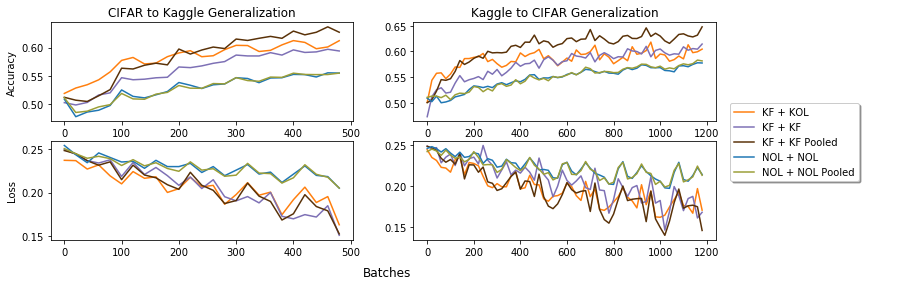

In [23]:
fig, axarr = plt.subplots(2,2, sharex=False)
fig.text(0.39, 0.0, 'Batches', ha='center', fontsize=12)
# fig.suptitle('Generalization on Cat Vs Dog Image Classification')
dataset='CIFAR -> KAGGLE'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[0,0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], label=name, color=colordict[name])
for name, item in configuration.items():
    axarr[1,0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['loss'],color=colordict[name])
    
dataset='KAGGLE -> CIFAR'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[0,1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'],color=colordict[name])
for name, item in configuration.items():
    axarr[1,1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['loss'],color=colordict[name])
    

axarr[0,0].set(title='CIFAR to Kaggle Generalization')
axarr[0,1].set(title='Kaggle to CIFAR Generalization')    
axarr[0,0].set(ylabel='Accuracy')
axarr[1,0].set(ylabel='Loss')
lgd = fig.legend(loc='center right', shadow=True, bbox_to_anchor=(1,.5))
fig.set_figheight(4)
fig.set_figwidth(12)
fig.subplots_adjust(left=0, right=.77)
fig.show()

In [28]:
fig.savefig('/home/ephy/Projects/tda_convolution/fig/catsVsDogsGeneral_Newpoly.png', dpi=300, bbox_inches='tight')

In [36]:
for name, config in configs.items():
    config['imageDim']=(28,28)
    config['classes']=10
    config['train_X']=mnist_train_X
    config['train_y']=mnist_train_y
    config['test_y']=train_y
    config['test_X']=train_X
    config['dataset']='MNIST -> SVHN'

In [37]:
results['MNIST -> SVHN'] = topnet.run_configs(configs, None)

In [38]:
for name, config in configs.items():
    config['imageDim']=(28,28)
    config['classes']=10
    config['train_X']=train_X
    config['train_y']=train_y
    config['test_y']=mnist_train_y
    config['test_X']=mnist_train_X
    config['dataset']='SVHN -> MNIST'

In [39]:
results['SVHN -> MNIST'] = topnet.run_configs(configs, None)

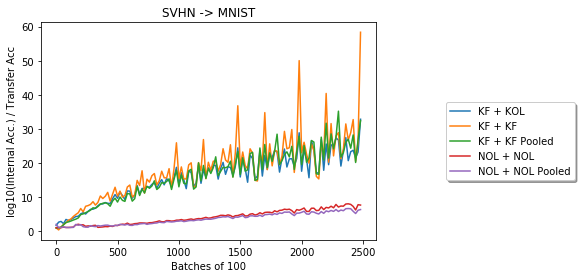

In [50]:
dataset='SVHN -> MNIST'
configuration=results[dataset]
for name, item in configuration.items():
    plt.plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies']/(item['loss']), label=name)    
plt.ylabel('log10(Internal Acc.) / Transfer Acc')
plt.xlabel('Batches of '+ str(next(iter(configuration.items()))[1]['config']['batchSize']))
plt.title(dataset)
legend = plt.legend(loc='lower right', shadow=True, bbox_to_anchor=(1.61, 0.25))
plt.show()

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


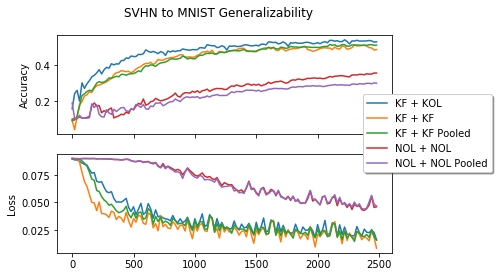

In [51]:
fig, axarr = plt.subplots(2, sharex=True)
fig.set()
fig.suptitle('SVHN to MNIST Generalizability')
dataset='SVHN -> MNIST'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], label=name)
for name, item in configuration.items():
    axarr[1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['loss'])
    
axarr[0].set(ylabel='Accuracy')
axarr[1].set(ylabel='Loss')
fig.legend(loc='center right', shadow=True, bbox_to_anchor=(1.15,.5))
fig.set_figheight(4)
fig.set_figwidth(6)
fig.show()

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


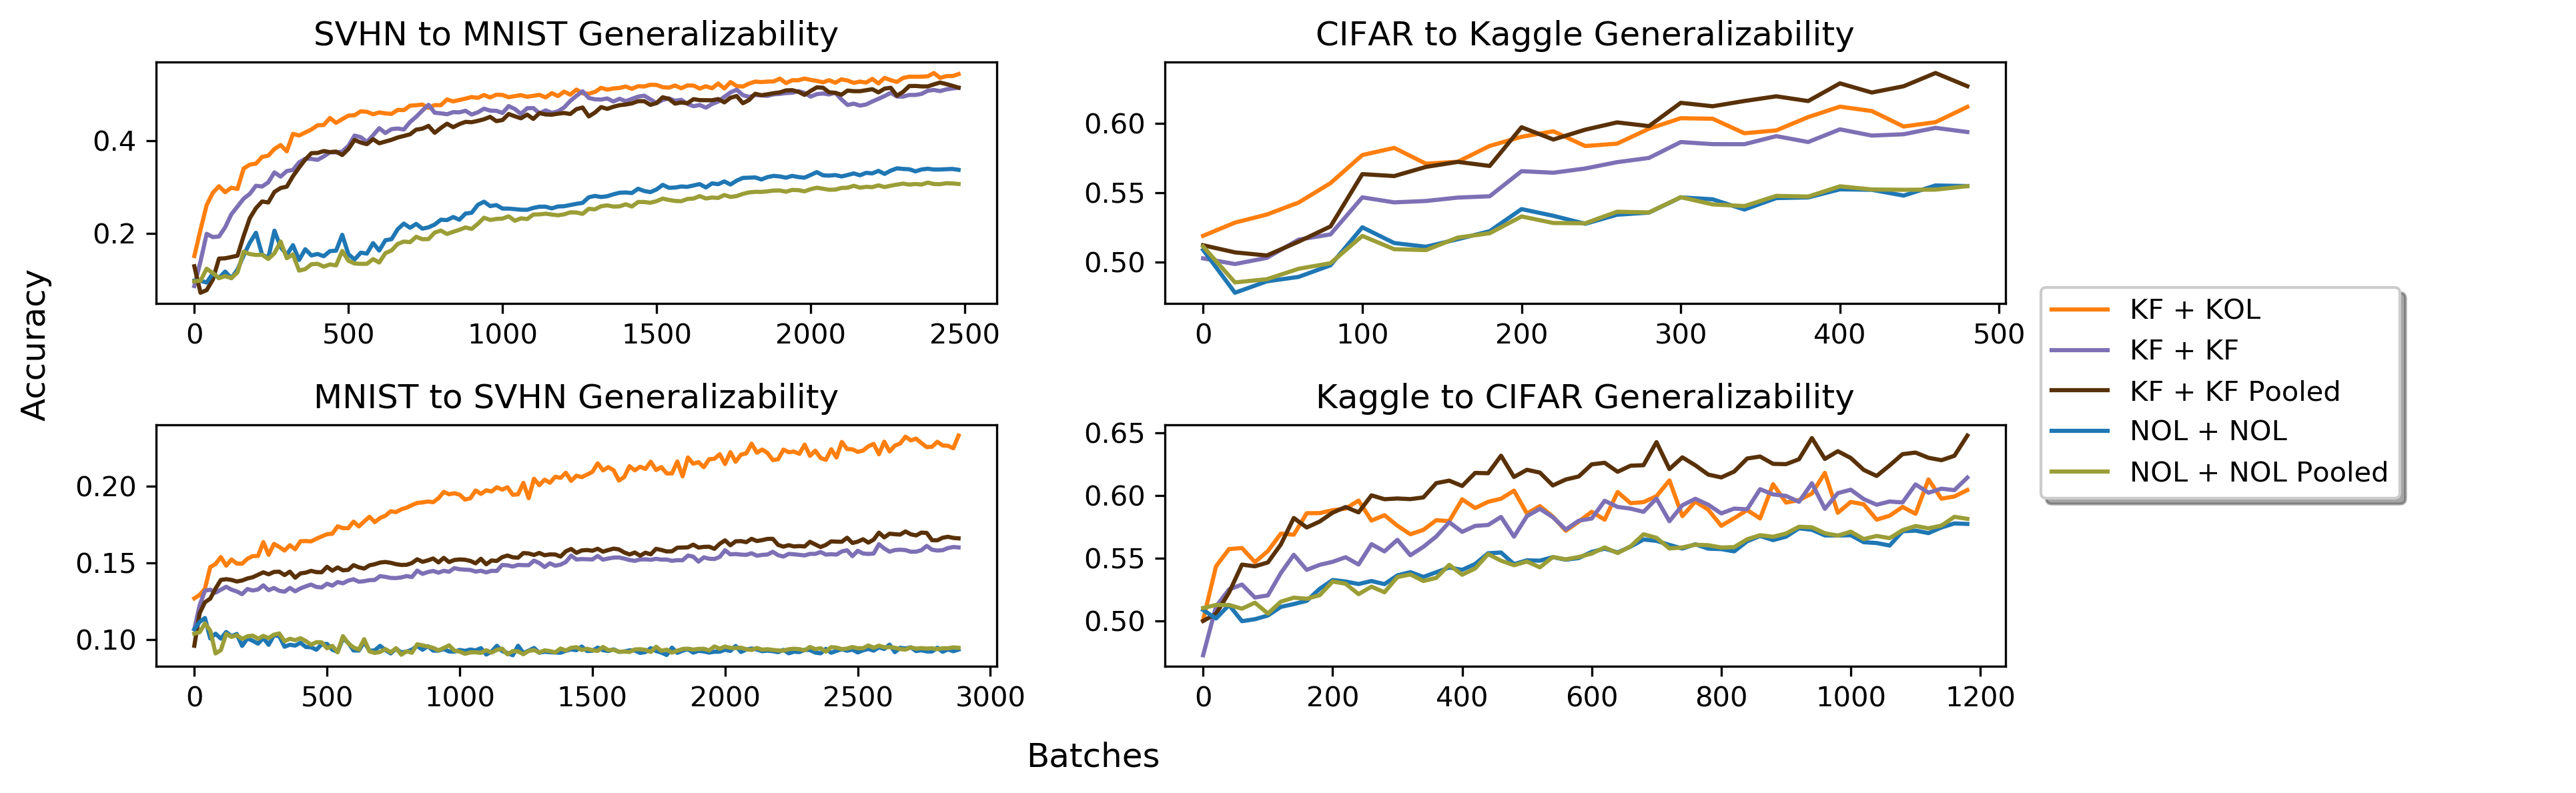

In [75]:
fig, axarr = plt.subplots(2,2)
fig.set()
fig.text(0.39, 0.0, 'Batches', ha='center', fontsize=12)
# fig.suptitle('MNIST to SVHN Generalizability')
dataset='SVHN -> MNIST'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[0,0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], label=name, color=colordict[name])

dataset='MNIST -> SVHN'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[1,0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], color=colordict[name])
    
dataset='CIFAR -> KAGGLE'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[0,1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], color=colordict[name])
    
dataset='KAGGLE -> CIFAR'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[1,1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'],color=colordict[name])

axarr[0,0].set(title='SVHN to MNIST Generalizability')
axarr[1,0].set(title='MNIST to SVHN Generalizability')
axarr[0,1].set(title='CIFAR to Kaggle Generalizability')
axarr[1,1].set(title='Kaggle to CIFAR Generalizability')
# axarr[0,0].set(ylabel='Accuracy')
# axarr[1,0].set(ylabel='Loss')
fig.text(-.05, 0.44, 'Accuracy', ha='center', fontsize=12, rotation=90)
fig.legend(loc='center right', shadow=True, bbox_to_anchor=(1.005,.5))
fig.set_figheight(4)
fig.set_figwidth(12)
fig.set_dpi(300)
fig.subplots_adjust(left=0, right=.77)
plt.subplots_adjust(hspace=.5)
fig.show()


In [76]:
fig.savefig('/home/ephy/Projects/tda_convolution/fig/digitAndDogsVsCatsGeneralizability.png', dpi=300, bbox_inches='tight')

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


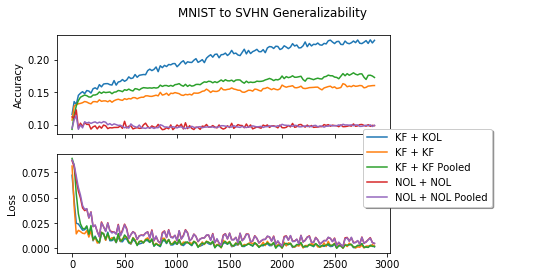

In [351]:
fig, axarr = plt.subplots(2, sharex=True)
fig.set()
fig.suptitle('MNIST to SVHN Generalizability')
dataset='MNIST -> SVHN'
configuration=results[dataset]
for name, item in configuration.items():
    axarr[0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], label=name)
for name, item in configuration.items():
    axarr[1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['loss'])
    
axarr[0].set(ylabel='Accuracy')
axarr[1].set(ylabel='Loss')
fig.legend(loc='center right', shadow=True, bbox_to_anchor=(1.15,.38))
fig.set_figheight(4)
fig.set_figwidth(6)
fig.show()

## Add some class stratified noise vector to images
- Add gaussian with mean and variance based on class

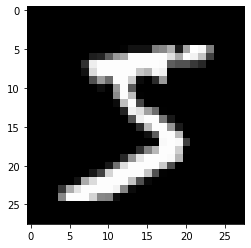

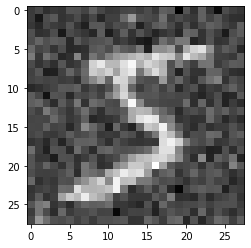

In [31]:
im = np.array(mnist_train_X)[0,0,...]
plt.imshow(im, cmap='gray')
plt.show()
sd = .2
mean = 1
im = im + sd*np.random.normal(im) + mean
plt.imshow(im, cmap='gray')
plt.show()

In [113]:
means = [.2,.5,.8]

for mean in means:
    np.random.seed(1)
    noiseD = dict()
    for c in np.arange(10):
            noiseD[str(c)]=[np.random.normal(mean,.2,1)[0],np.random.chisquare(1,1)[0]*(.2**2)]

    mnist_train_y_numeric = np.array([i for vec in mnist_train_y for i, val in enumerate(vec) if val])

    mnist_train_X_noisy = np.array(copy.copy(mnist_train_X))

    for i,c in enumerate(mnist_train_y_numeric):
        mnist_train_X_noisy[i] = mnist_train_X_noisy[i] + noiseD[str(c)][1]*np.random.normal(mnist_train_X_noisy[i]) + noiseD[str(c)][0]

    # Re-scale noisy images to make sure they are 0-1
    mnist_train_X_noisy = torch.tensor((mnist_train_X_noisy - np.min(mnist_train_X_noisy))/(np.max(mnist_train_X_noisy)-np.min(mnist_train_X_noisy)), dtype=torch.float32)

    configs=dict()
    config = dict()
    config['weights_config']=[None,None]
    config['freeze_layers']=[False,False]
    config['membership_config']=[None,None]
    config['convLayerSpecs']=[(1,64,3),(64,64,3)]
    config['pools']=[None,None]
    config['activations']=['F.relu', 'F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(28,28)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X_noisy
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='SVHN'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['NOL + NOL'] = config

    config = dict()
    config['weights_config']=[[('Klein',8,8,3,None)],None]
    config['freeze_layers']=[True,False]
    config['membership_config']=[None,[('Klein',8,8,3,.65)]]
    config['convLayerSpecs']=[(1,64,3),(64,64,3)]
    config['pools']=[None,None]
    config['activations']=[None, 'F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(28,28)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X_noisy
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='CIFAR -> KAGGLE'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['KF + KOL'] = config

    config = dict()
    config['weights_config']=[[('Klein',8,8,3,None)],None]
    config['freeze_layers']=[True,False]
    config['membership_config']=[None,None]
    config['convLayerSpecs']=[(1,64,3),(64,64,3)]
    config['pools']=[None,None]
    config['activations']=[None, 'F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(28,28)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X_noisy
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='CIFAR -> KAGGLE'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['KF + NOL'] = config

    config = dict()
    config['weights_config']=[[('Circle',3,64,None)],None]
    config['freeze_layers']=[True,False]
    config['membership_config']=[None,[('Circle',3,64,.35)]]
    config['convLayerSpecs']=[(1,64,3),(64,64,3)]
    config['pools']=[None,None]
    config['activations']=[None, 'F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(28,28)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X_noisy
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='CIFAR -> KAGGLE'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['CF + COL'] = config

    config = dict()
    config['weights_config']=[[('Circle',3,64,None)],None]
    config['freeze_layers']=[True,False]
    config['membership_config']=[None,None]
    config['convLayerSpecs']=[(1,64,3),(64,64,3)]
    config['pools']=[None,None]
    config['activations']=[None, 'F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(28,28)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X_noisy
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='CIFAR -> KAGGLE'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['CF + NOL'] = config

    test[('Noisy MNIST,'+str(mean)+ ',.2')] = topnet.run_configs(configs, None)

    # Add noise to test set
    mnist_test_y_numeric = np.array([i for vec in mnist_test_y for i, val in enumerate(vec) if val])
    mnist_test_X_noisy = np.array(copy.copy(mnist_test_X))

    for i,c in enumerate(mnist_test_y_numeric):
        mnist_test_X_noisy[i] = mnist_test_X_noisy[i] + noiseD[str(c)][1]*np.random.normal(mnist_test_X_noisy[i]) + noiseD[str(c)][0]

    # Re-scale noisy images to make sure they are 0-1
    mnist_test_X_noisy = torch.tensor((mnist_test_X_noisy - np.min(mnist_test_X_noisy))/(np.max(mnist_test_X_noisy)-np.min(mnist_test_X_noisy)), dtype=torch.float32)

    for name, config in configs.items():
        config['test_X']=mnist_test_X_noisy
        config['test_y']=mnist_test_y
        config['train_y']=mnist_train_y
        config['train_X']=mnist_train_X
        config['batchesPerTest']=50
        config['epochs']=10
        config['learning_rate']=1e-6

    test[('Noisy Test MNIST,'+str(mean)+ ',.2')] = topnet.run_configs(configs, None)
#     np.save('/home/ephy/Projects/tda_convolution/data/synthetic_mnist_test_varried_meanAndSD', test)


In [133]:
sds = [0,.2,.4,.6,.8]
mean=.2
for sd in sds:
    np.random.seed(1)
    noiseD = dict()
    for c in np.arange(10):
            noiseD[str(c)]=[np.random.normal(.2,sd,1)[0],np.random.chisquare(1,1)[0]*(sd**2)]

    mnist_train_y_numeric = np.array([i for vec in mnist_train_y for i, val in enumerate(vec) if val])

    mnist_train_X_noisy = np.array(copy.copy(mnist_train_X))

    for i,c in enumerate(mnist_train_y_numeric):
        mnist_train_X_noisy[i] = mnist_train_X_noisy[i] + noiseD[str(c)][1]*np.random.normal(mnist_train_X_noisy[i]) + noiseD[str(c)][0]

    # Re-scale noisy images to make sure they are 0-1
    mnist_train_X_noisy = torch.tensor((mnist_train_X_noisy - np.min(mnist_train_X_noisy))/(np.max(mnist_train_X_noisy)-np.min(mnist_train_X_noisy)), dtype=torch.float32)

    configs=dict()
    config = dict()
    config['weights_config']=[None,None]
    config['freeze_layers']=[False,False]
    config['membership_config']=[None,None]
    config['convLayerSpecs']=[(1,64,3),(64,64,3)]
    config['pools']=[None,None]
    config['activations']=['F.relu', 'F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(28,28)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X_noisy
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='SVHN'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['NOL + NOL'] = config

    config = dict()
    config['weights_config']=[[('Klein',8,8,3,None)],None]
    config['freeze_layers']=[True,False]
    config['membership_config']=[None,[('Klein',8,8,3,.65)]]
    config['convLayerSpecs']=[(1,64,3),(64,64,3)]
    config['pools']=[None,None]
    config['activations']=[None, 'F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(28,28)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X_noisy
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='CIFAR -> KAGGLE'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['KF + KOL'] = config

    config = dict()
    config['weights_config']=[[('Klein',8,8,3,None)],None]
    config['freeze_layers']=[True,False]
    config['membership_config']=[None,None]
    config['convLayerSpecs']=[(1,64,3),(64,64,3)]
    config['pools']=[None,None]
    config['activations']=[None, 'F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(28,28)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X_noisy
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='CIFAR -> KAGGLE'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['KF + NOL'] = config

    config = dict()
    config['weights_config']=[[('Circle',3,64,None)],None]
    config['freeze_layers']=[True,False]
    config['membership_config']=[None,[('Circle',3,64,.35)]]
    config['convLayerSpecs']=[(1,64,3),(64,64,3)]
    config['pools']=[None,None]
    config['activations']=[None, 'F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(28,28)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X_noisy
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='CIFAR -> KAGGLE'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['CF + COL'] = config

    config = dict()
    config['weights_config']=[[('Circle',3,64,None)],None]
    config['freeze_layers']=[True,False]
    config['membership_config']=[None,None]
    config['convLayerSpecs']=[(1,64,3),(64,64,3)]
    config['pools']=[None,None]
    config['activations']=[None, 'F.relu']
    config['learning_rate']=1e-5
    config['classes']=10
    config['imageDim']=(28,28)
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X_noisy
    config['batchesPerTest']=20
    config['batchSize']=100
    config['epochs']=5
    config['dataset']='CIFAR -> KAGGLE'
    config['loss_function']='nn.MSELoss'
    config['device'] = device

    configs['CF + NOL'] = config

    test[('Noisy MNIST,.2,'+str(sd))] = topnet.run_configs(configs, None)

    # Add noise to test set
    mnist_test_y_numeric = np.array([i for vec in mnist_test_y for i, val in enumerate(vec) if val])
    mnist_test_X_noisy = np.array(copy.copy(mnist_test_X))

    for i,c in enumerate(mnist_test_y_numeric):
        mnist_test_X_noisy[i] = mnist_test_X_noisy[i] + noiseD[str(c)][1]*np.random.normal(mnist_test_X_noisy[i]) + noiseD[str(c)][0]

    # Re-scale noisy images to make sure they are 0-1
    mnist_test_X_noisy = torch.tensor((mnist_test_X_noisy - np.min(mnist_test_X_noisy))/(np.max(mnist_test_X_noisy)-np.min(mnist_test_X_noisy)), dtype=torch.float32)

    for name, config in configs.items():
        config['test_X']=mnist_test_X_noisy
        config['test_y']=mnist_test_y
        config['train_y']=mnist_train_y
        config['train_X']=mnist_train_X
        config['batchesPerTest']=50
        config['epochs']=10
        config['learning_rate']=1e-6

    test[('Noisy Test MNIST,.2,'+str(sd))] = topnet.run_configs(configs, None)
#     np.save('/home/ephy/Projects/tda_convolution/data/synthetic_mnist_test_varried_meanAndSD', test)


In [100]:
np.random.seed(1)
noiseD = dict()
for c in np.arange(10):
        noiseD[str(c)]=[np.random.normal(0,.2,1)[0],np.random.chisquare(1,1)[0]*(0**2)]

In [101]:
noiseD

{'0': [0.32486907273264837, 0.0],
 '1': [-0.12235128273001508, 0.0],
 '2': [-0.10563435045269115, 0.0],
 '3': [-0.21459372443123412, 0.0],
 '4': [0.06380781921141972, 0.0],
 '5': [-0.04987407509548202, 0.0],
 '6': [-0.0644834408027015, 0.0],
 '7': [-0.07681087093368313, 0.0],
 '8': [-0.03448564151008715, 0.0],
 '9': [-0.17557168358427436, 0.0]}

In [91]:
mnist_train_y_numeric = np.array([i for vec in mnist_train_y for i, val in enumerate(vec) if val])

mnist_train_X_noisy = np.array(copy.copy(mnist_train_X))

for i,c in enumerate(mnist_train_y_numeric):
    mnist_train_X_noisy[i] = mnist_train_X_noisy[i] + noiseD[str(c)][1]*np.random.normal(mnist_train_X_noisy[i]) + noiseD[str(c)][0]

# Re-scale noisy images to make sure they are 0-1
mnist_train_X_noisy = torch.tensor((mnist_train_X_noisy - np.min(mnist_train_X_noisy))/(np.max(mnist_train_X_noisy)-np.min(mnist_train_X_noisy)), dtype=torch.float32)

In [36]:
configs=dict()
config = dict()
config['weights_config']=[None,None]
config['freeze_layers']=[False,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=['F.relu', 'F.relu']
config['learning_rate']=1e-5
config['classes']=10
config['imageDim']=(28,28)
config['test_X']=mnist_test_X
config['test_y']=mnist_test_y
config['train_y']=mnist_train_y
config['train_X']=mnist_train_X_noisy
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='SVHN'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL + NOL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,[('Klein',8,8,3,.65)]]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=10
config['imageDim']=(28,28)
config['test_X']=mnist_test_X
config['test_y']=mnist_test_y
config['train_y']=mnist_train_y
config['train_X']=mnist_train_X_noisy
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='CIFAR -> KAGGLE'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + KOL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=10
config['imageDim']=(28,28)
config['test_X']=mnist_test_X
config['test_y']=mnist_test_y
config['train_y']=mnist_train_y
config['train_X']=mnist_train_X_noisy
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='CIFAR -> KAGGLE'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + NOL'] = config

config = dict()
config['weights_config']=[[('Circle',3,64,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,[('Circle',3,64,.35)]]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=10
config['imageDim']=(28,28)
config['test_X']=mnist_test_X
config['test_y']=mnist_test_y
config['train_y']=mnist_train_y
config['train_X']=mnist_train_X_noisy
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='CIFAR -> KAGGLE'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['CF + COL'] = config

config = dict()
config['weights_config']=[[('Circle',3,64,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=10
config['imageDim']=(28,28)
config['test_X']=mnist_test_X
config['test_y']=mnist_test_y
config['train_y']=mnist_train_y
config['train_X']=mnist_train_X_noisy
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='CIFAR -> KAGGLE'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['CF + NOL'] = config

In [93]:
# test=dict()
test['Noisy MNIST 0,.2'] = topnet.run_configs(configs, None)

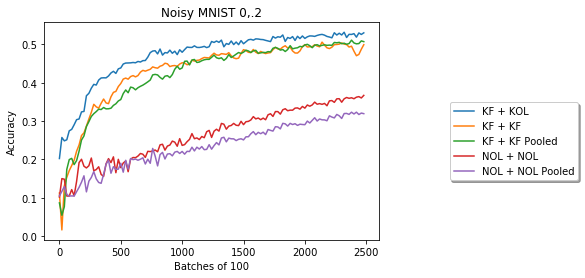

In [94]:
topnet.plot_results(results=test, dataset='Noisy MNIST 0,.2',item='accuracies')

In [95]:
# Add noise to test set
mnist_test_y_numeric = np.array([i for vec in mnist_test_y for i, val in enumerate(vec) if val])
mnist_test_X_noisy = np.array(copy.copy(mnist_test_X))

for i,c in enumerate(mnist_test_y_numeric):
    mnist_test_X_noisy[i] = mnist_test_X_noisy[i] + noiseD[str(c)][1]*np.random.normal(mnist_test_X_noisy[i]) + noiseD[str(c)][0]

# Re-scale noisy images to make sure they are 0-1
mnist_test_X_noisy = torch.tensor((mnist_test_X_noisy - np.min(mnist_test_X_noisy))/(np.max(mnist_test_X_noisy)-np.min(mnist_test_X_noisy)), dtype=torch.float32)

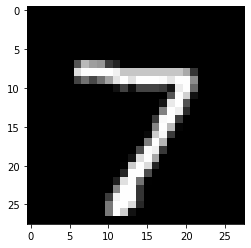

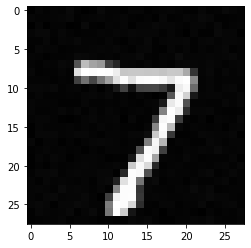

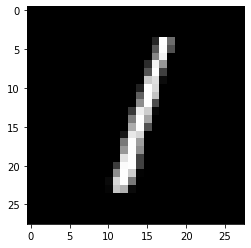

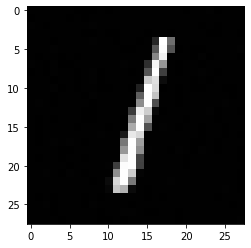

In [96]:
plt.imshow(mnist_test_X[0,0],cmap='gray')
plt.show()
plt.imshow(mnist_test_X_noisy[0,0],cmap='gray')
plt.show()
plt.imshow(mnist_test_X[2,0],cmap='gray')
plt.show()
plt.imshow(mnist_test_X_noisy[2,0],cmap='gray')
plt.show()

In [97]:
for name, config in configs.items():
    config['test_X']=mnist_test_X_noisy
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X
    config['batchesPerTest']=50
    config['epochs']=10
    config['learning_rate']=1e-6

In [98]:
test['Noisy Test MNIST 0,0'] = topnet.run_configs(configs, None)

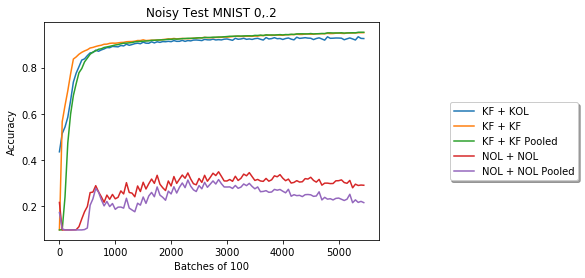

In [99]:
topnet.plot_results(results=test, dataset='Noisy Test MNIST 0,0',item='accuracies')

Save these data since these are very long experiments

In [108]:
# np.save('/home/ephy/Projects/tda_convolution/data/synthetic_mnist_test_varried', test)
# test = np.load('/home/ephy/Projects/tda_convolution/data/synthetic_mnist_test_varried.npy', allow_pickle=True)
# test = test.item()

In [77]:
test = np.load('/home/ephy/Projects/tda_convolution/data/synthetic_mnist_test_varried_meanAndSD.npy', allow_pickle=True)
test = test.item()

In [78]:
levels = ['Noisy MNIST,.2,0','Noisy MNIST,.2,0.2','Noisy MNIST,.2,0.4','Noisy MNIST,.2,0.6','Noisy Test MNIST,.2,0.8','Noisy Test MNIST,.2,0','Noisy Test MNIST,.2,0.2','Noisy Test MNIST,.2,0.4','Noisy Test MNIST,.2,0.6','Noisy Test MNIST,.2,0.8',]
graph_dat_1 = np.empty((10,3))
graph_dat_5 = np.empty((10,3))
for i,level in enumerate(levels):
    graph_dat_1[i]= [test[level]['NOL + NOL']['accuracies'][9], test[level]['KF + KOL']['accuracies'][9], test[level]['CF + COL']['accuracies'][9]]
for i,level in enumerate(levels):
    graph_dat_5[i]= [test[level]['NOL + NOL']['accuracies'][54], test[level]['KF + KOL']['accuracies'][54], test[level]['CF + COL']['accuracies'][9]]

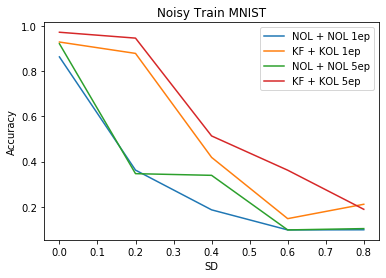

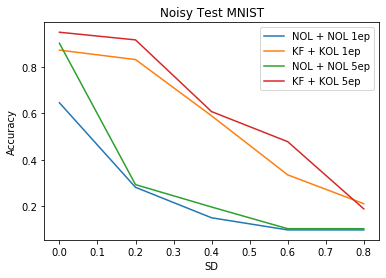

In [79]:
plt.plot([0,.2,.4,.6,.8], graph_dat_1[...,0][0:5], label='NOL + NOL 1ep')
plt.plot([0,.2,.4,.6,.8], graph_dat_1[...,1][0:5], label='KF + KOL 1ep')
plt.plot([0,.2,.4,.6,.8], graph_dat_5[...,0][0:5], label='NOL + NOL 5ep')
plt.plot([0,.2,.4,.6,.8], graph_dat_5[...,1][0:5], label='KF + KOL 5ep')
plt.legend()
plt.xlabel('SD')
plt.ylabel('Accuracy')
plt.title('Noisy Train MNIST')
plt.show()

plt.plot([0,.2,.4,.6,.8], graph_dat_1[...,0][5:10], label='NOL + NOL 1ep')
plt.plot([0,.2,.4,.6,.8], graph_dat_1[...,1][5:10], label='KF + KOL 1ep')
plt.plot([0,.2,.4,.6,.8], graph_dat_5[...,0][5:10], label='NOL + NOL 5ep')
plt.plot([0,.2,.4,.6,.8], graph_dat_5[...,1][5:10], label='KF + KOL 5ep')
plt.legend()
plt.title('Noisy Test MNIST')
plt.xlabel('SD')
plt.ylabel('Accuracy')
plt.show()

In [158]:
levels = ['Noisy MNIST 0,.2','Noisy MNIST,0.2,.2','Noisy MNIST,0.5,.2','Noisy MNIST,0.8,.2','Noisy Test MNIST 0,.2','Noisy Test MNIST,0.2,.2','Noisy Test MNIST,0.5,.2','Noisy Test MNIST,0.8,.2']
graph_dat_1 = np.empty((8,2))
graph_dat_5 = np.empty((8,2))
for i,level in enumerate(levels):
    graph_dat_1[i]= [test[level]['NOL + NOL']['accuracies'][9], test[level]['KF + KOL']['accuracies'][9]]
for i,level in enumerate(levels):
    graph_dat_5[i]= [test[level]['NOL + NOL']['accuracies'][54], test[level]['KF + KOL']['accuracies'][54]]

dict_keys(['Noisy MNIST 0,.2', 'Noisy Test MNIST 0,.2', 'Noisy MNIST,0.2,.2', 'Noisy Test MNIST,0.2,.2', 'Noisy MNIST,0.5,.2', 'Noisy Test MNIST,0.5,.2', 'Noisy MNIST,0.8,.2', 'Noisy Test MNIST,0.8,.2', 'Noisy Test MNIST,.2,0', 'Noisy Test MNIST,.2,0.2', 'Noisy Test MNIST,.2,0.4', 'Noisy Test MNIST,.2,0.6', 'Noisy Test MNIST,.2,0.8', 'Noisy MNIST,.2,0', 'Noisy MNIST,.2,0.2', 'Noisy MNIST,.2,0.4', 'Noisy MNIST,.2,0.6', 'Noisy MNIST,.2,0.8'])


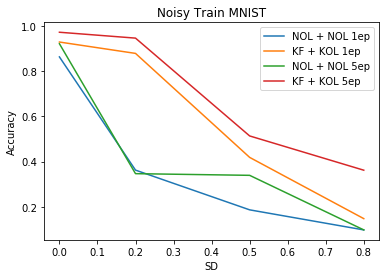

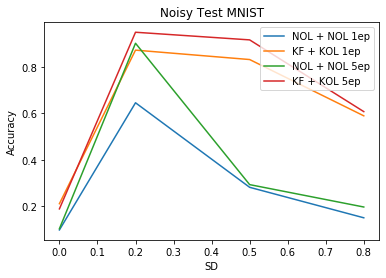

In [80]:
plt.plot([0,.2,.5,.8], graph_dat_1[...,0][0:4], label='NOL + NOL 1ep')
plt.plot([0,.2,.5,.8], graph_dat_1[...,1][0:4], label='KF + KOL 1ep')
plt.plot([0,.2,.5,.8], graph_dat_5[...,0][0:4], label='NOL + NOL 5ep')
plt.plot([0,.2,.5,.8], graph_dat_5[...,1][0:4], label='KF + KOL 5ep')
plt.legend()
plt.xlabel('SD')
plt.ylabel('Accuracy')
plt.title('Noisy Train MNIST')
plt.show()

plt.plot([0,.2,.5,.8], graph_dat_1[...,0][4:8], label='NOL + NOL 1ep')
plt.plot([0,.2,.5,.8], graph_dat_1[...,1][4:8], label='KF + KOL 1ep')
plt.plot([0,.2,.5,.8], graph_dat_5[...,0][4:8], label='NOL + NOL 5ep')
plt.plot([0,.2,.5,.8], graph_dat_5[...,1][4:8], label='KF + KOL 5ep')
plt.legend()
plt.title('Noisy Test MNIST')
plt.xlabel('SD')
plt.ylabel('Accuracy')
plt.show()

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


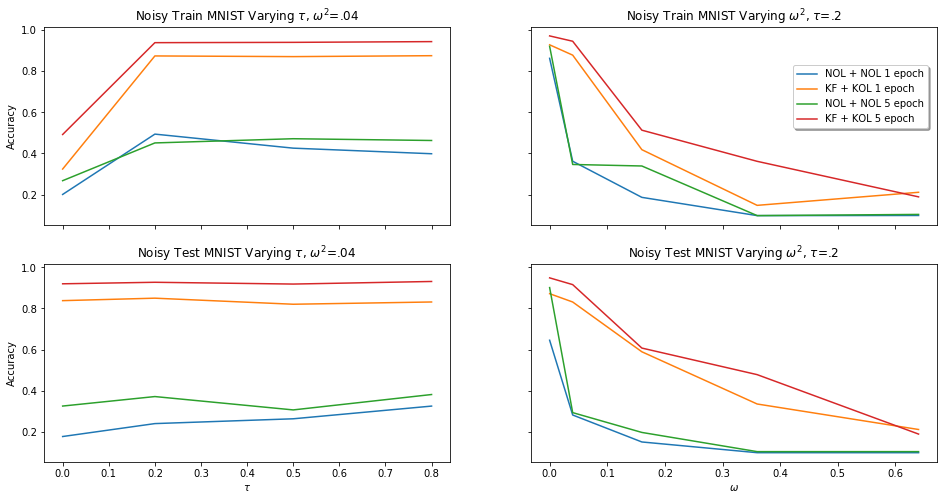

In [83]:
fig, axarr = plt.subplots(2,2, sharex='col',sharey=True)
# fig.suptitle('Noisy Test-Set MNIST')

levels = ['Noisy MNIST 0,.2','Noisy MNIST,0.2,.2','Noisy MNIST,0.5,.2','Noisy MNIST,0.8,.2','Noisy Test MNIST 0,.2','Noisy Test MNIST,0.2,.2','Noisy Test MNIST,0.5,.2','Noisy Test MNIST,0.8,.2']
graph_dat_1 = np.empty((8,2))
graph_dat_5 = np.empty((8,2))
for i,level in enumerate(levels):
    graph_dat_1[i]= [test[level]['NOL + NOL']['accuracies'][9], test[level]['KF + KOL']['accuracies'][9]]
for i,level in enumerate(levels):
    graph_dat_5[i]= [test[level]['NOL + NOL']['accuracies'][54], test[level]['KF + KOL']['accuracies'][54]]

axarr[0,0].plot([0,.2,.5,.8], graph_dat_1[...,0][0:4], label='NOL + NOL 1 epoch')
axarr[0,0].plot([0,.2,.5,.8], graph_dat_1[...,1][0:4], label='KF + KOL 1 epoch')
axarr[0,0].plot([0,.2,.5,.8], graph_dat_5[...,0][0:4], label='NOL + NOL 5 epoch')
axarr[0,0].plot([0,.2,.5,.8], graph_dat_5[...,1][0:4], label='KF + KOL 5 epoch')

axarr[1,0].plot([0,.2,.5,.8], graph_dat_1[...,0][4:8])
axarr[1,0].plot([0,.2,.5,.8], graph_dat_1[...,1][4:8])
axarr[1,0].plot([0,.2,.5,.8], graph_dat_5[...,0][4:8])
axarr[1,0].plot([0,.2,.5,.8], graph_dat_5[...,1][4:8])

levels = ['Noisy MNIST,.2,0','Noisy MNIST,.2,0.2','Noisy MNIST,.2,0.4','Noisy MNIST,.2,0.6','Noisy Test MNIST,.2,0.8','Noisy Test MNIST,.2,0','Noisy Test MNIST,.2,0.2','Noisy Test MNIST,.2,0.4','Noisy Test MNIST,.2,0.6','Noisy Test MNIST,.2,0.8',]
graph_dat_1 = np.empty((10,3))
graph_dat_5 = np.empty((10,3))
for i,level in enumerate(levels):
    graph_dat_1[i]= [test[level]['NOL + NOL']['accuracies'][9], test[level]['KF + KOL']['accuracies'][9], test[level]['CF + COL']['accuracies'][9]]
for i,level in enumerate(levels):
    graph_dat_5[i]= [test[level]['NOL + NOL']['accuracies'][54], test[level]['KF + KOL']['accuracies'][54], test[level]['CF + COL']['accuracies'][9]]

axarr[0,1].plot([0,.2**2,.4**2,.6**2,.8**2], graph_dat_1[...,0][0:5])
axarr[0,1].plot([0,.2**2,.4**2,.6**2,.8**2], graph_dat_1[...,1][0:5])
axarr[0,1].plot([0,.2**2,.4**2,.6**2,.8**2], graph_dat_5[...,0][0:5])
axarr[0,1].plot([0,.2**2,.4**2,.6**2,.8**2], graph_dat_5[...,1][0:5])

axarr[1,1].plot([0,.2**2,.4**2,.6**2,.8**2], graph_dat_1[...,0][5:10])
axarr[1,1].plot([0,.2**2,.4**2,.6**2,.8**2], graph_dat_1[...,1][5:10])
axarr[1,1].plot([0,.2**2,.4**2,.6**2,.8**2], graph_dat_5[...,0][5:10])
axarr[1,1].plot([0,.2**2,.4**2,.6**2,.8**2], graph_dat_5[...,1][5:10])

axarr[0,0].set(title=r'Noisy Train MNIST Varying $\tau$, $\omega^2$=.04')
axarr[1,0].set(title=r'Noisy Test MNIST Varying $\tau$, $\omega^2$=.04')
axarr[0,1].set(title=r'Noisy Train MNIST Varying $\omega^2$, $\tau$=.2')
axarr[1,1].set(title=r'Noisy Test MNIST Varying $\omega^2$, $\tau$=.2')
axarr[0,0].set(ylabel='Accuracy')
axarr[1,0].set(ylabel='Accuracy')
axarr[1,0].set(xlabel=r'$\tau$')
axarr[1,1].set(xlabel=r'$\omega$')
fig.legend(loc='center right', shadow=True, bbox_to_anchor=(.81,.7))
fig.set_figheight(8)
fig.set_figwidth(16)
fig.show()

In [84]:
fig.savefig('/home/ephy/Projects/tda_convolution/fig/synthSensitivities.png', dpi=300, bbox_inches='tight')

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


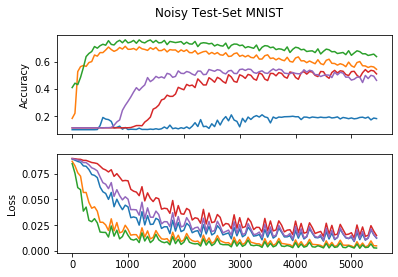

In [64]:
fig, axarr = plt.subplots(2, sharex=True)
fig.set()
fig.suptitle('Noisy Test-Set MNIST')
dataset='Noisy Test MNIST'
configuration=test[dataset]
for name, item in configuration.items():
    axarr[0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], label=name)
for name, item in configuration.items():
    axarr[1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['loss'])
    
axarr[0].set(ylabel='Accuracy')
axarr[1].set(ylabel='Loss')
# fig.legend(loc='center right', shadow=True, bbox_to_anchor=(.91,.5))
fig.set_figheight(4)
fig.set_figwidth(6)
fig.show()

In [232]:
fig.savefig('/home/ephy/Projects/tda_convolution/fig/noisyTestMnist.png', dpi=300, bbox_inches='tight')

{'NOL + NOL': '#1f77b4', 'KF + KOL': '#ff7f0e', 'KF + NOL': '#2ca02c', 'CF + COL': '#d62728', 'CF + NOL': '#9467bd'}


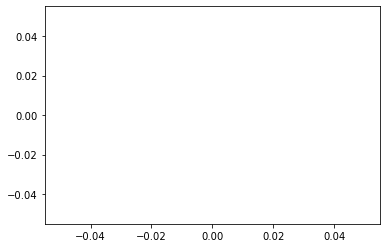

In [247]:
# fig, ax = plt.subplots(1)
# dataset='Noisy Test MNIST'
# configuration=test[dataset]
# lines=[]
# names=[]
# for name, item in configuration.items():
#     names.append(name)
#     lines.append(ax.plot([0],label=name))
# colordict=dict()
# for i,l in enumerate(lines):
#     colordict[names[i]]=l[0].get_c()
# print(colordict)

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


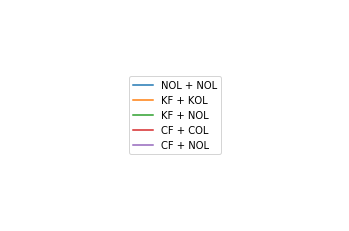

In [209]:
fig, ax = plt.subplots(1)
dataset='Noisy Test MNIST'
configuration=test[dataset]
ax.set_axis_off()  
for name, item in configuration.items():
    lines.append(ax.plot([0],label=name))

fig.legend(loc='center')
fig.set_figheight(4)
fig.set_figwidth(6)
fig.show()

In [213]:
fig.savefig('/home/ephy/Projects/tda_convolution/fig/noisyTestLegend.png', dpi=300, bbox_inches='tight')

In [236]:
legend=cv2.imread('/home/ephy/Projects/tda_convolution/fig/noisyTestLegend.png')
crop_factor_y = legend.shape[0]*.31
crop_factor_x = legend.shape[1]*.365
legend = legend[:,int(crop_factor_x):int(legend.shape[1]-crop_factor_x),:]
cv2.imwrite('/home/ephy/Projects/tda_convolution/fig/noisyTestLegendCropped.png',legend)

True

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


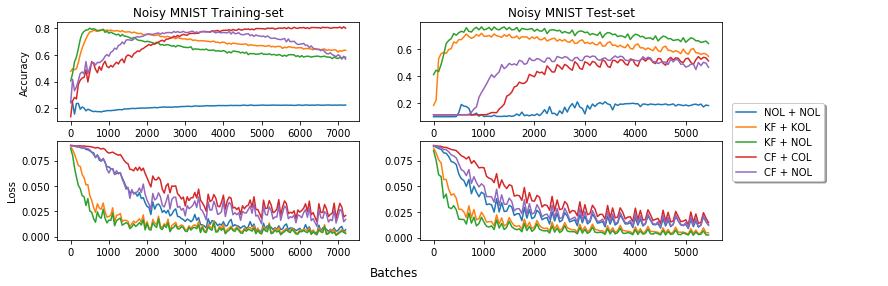

In [68]:
fig, axarr = plt.subplots(2,2)
fig.text(0.39, 0.0, 'Batches', ha='center', fontsize=12)
dataset='Noisy MNIST'
configuration=test[dataset]
for name, item in configuration.items():
    axarr[0,0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], label=name, color=colordict[name])
for name, item in configuration.items():
    axarr[1,0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['loss'], color=colordict[name])
dataset='Noisy Test MNIST'
configuration=test[dataset]
for name, item in configuration.items():
    axarr[0,1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], color=colordict[name])
for name, item in configuration.items():
    axarr[1,1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['loss'], color=colordict[name])
axarr[0,0].set(title='Noisy MNIST Training-set')
axarr[0,1].set(title='Noisy MNIST Test-set')
axarr[0,0].set(ylabel='Accuracy')
axarr[1,0].set(ylabel='Loss')
fig.legend(loc='center right', shadow=True, bbox_to_anchor=(.96,.5))
fig.set_figheight(4)
fig.set_figwidth(12)
fig.subplots_adjust(left=0, right=.77)
fig.show()

In [69]:
fig.savefig('/home/ephy/Projects/tda_convolution/fig/noisyMnistTest.png', dpi=300, bbox_inches='tight')

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


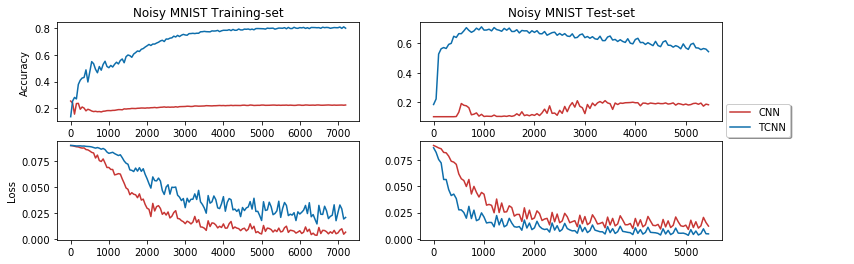

In [394]:
## Version for GC
gc_color_dict1 = {'CF + COL': '#0e6eab', 'NOL + NOL': '#c73634'}
gc_color_dict2 = {'KF + KOL': '#0e6eab', 'NOL + NOL': '#c73634'}
name_dict = {'KF + KOL': 'TCNN','CF + COL': 'TCNN', 'NOL + NOL': 'CNN'}

fig, axarr = plt.subplots(2,2)
dataset='Noisy MNIST'
configuration=test[dataset]
for name, item in configuration.items():
    if name in list(gc_color_dict1.keys()):
        axarr[0,0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
                 item['accuracies'], label=name_dict[name], color=gc_color_dict1[name])
for name, item in configuration.items():
    if name in list(gc_color_dict1.keys()):
        axarr[1,0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
                 item['loss'], color=gc_color_dict1[name])
dataset='Noisy Test MNIST'
configuration=test[dataset]
for name, item in configuration.items():
    if name in list(gc_color_dict2.keys()):
        axarr[0,1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
                 item['accuracies'], color=gc_color_dict2[name])
for name, item in configuration.items():
    if name in list(gc_color_dict2.keys()):
        axarr[1,1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
                 item['loss'], color=gc_color_dict2[name])
axarr[0,0].set(title='Noisy MNIST Training-set')
axarr[0,1].set(title='Noisy MNIST Test-set')
axarr[0,0].set(ylabel='Accuracy')
axarr[1,0].set(ylabel='Loss')
fig.legend(loc='center right', shadow=True, bbox_to_anchor=(.92,.5))
fig.set_figheight(4)
fig.set_figwidth(12)
fig.subplots_adjust(left=0, right=.77)
fig.show()
# fig.savefig('/home/ephy/Projects/tda_convolution/fig/noisyMnistTest_forGC.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axarr = plt.subplots(2, sharex=True)
fig.set()
dataset='Noisy MNIST'
configuration=test[dataset]
for name, item in configuration.items():
    axarr[0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], label=name)
for name, item in configuration.items():
    axarr[1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['loss'])
axxar[0,0].set(title=('Noisy Train-Set MNIST')
axxar[0,1].set(title=('Noisy Test-Set MNIST')               
axarr[0,0].set(ylabel='Accuracy')
axarr[1,0].set(ylabel='Loss')
fig.legend(loc='center right', shadow=True, bbox_to_anchor=(1.15,.5))
fig.set_figheight(4)
fig.set_figwidth(12)
fig.show()

## Same thing with rotation

In [270]:
import imutils

In [293]:
np.random.seed(100)
noiseD = dict()
for c in np.arange(10):
        noiseD[str(c)]=[np.random.normal(0,30,1)[0],np.random.chisquare(1,1)[0]]

In [294]:
noiseD

{'0': [-52.49296419164092, 0.36043036971089687],
 '1': [10.280412099825064, 4.45352075021602e-05],
 '2': [29.439623608536948, 0.03737738332658018],
 '3': [15.426565241831463, 3.190889440250128],
 '4': [-13.740809565078727, 2.001789495849105],
 '5': [13.054904643686763, 0.3727370043844846],
 '6': [-15.938411305557294, 0.061537654564184856],
 '7': [30.891980554000384, 6.471823180056381e-05],
 '8': [48.56944982025779, 0.022112071495025525],
 '9': [46.2481552354022, 0.002661005409088581]}

In [306]:
mnist_test_X_noisy = np.array(copy.copy(mnist_test_X))

for i,c in enumerate(mnist_test_y_numeric):
    rot = round(np.random.normal(noiseD[str(c)][0]+noiseD[str(c)][1]))
    mnist_test_X_noisy[i,0] = np.array(imutils.rotate(mnist_test_X_noisy[i,0],rot))
    
mnist_test_X_noisy = torch.tensor(mnist_test_X_noisy)

In [307]:
mnist_train_X_noisy = np.array(copy.copy(mnist_train_X))

for i,c in enumerate(mnist_train_y_numeric):
    rot = round(np.random.normal(noiseD[str(c)][0]+noiseD[str(c)][1]))
    mnist_train_X_noisy[i,0] = np.array(imutils.rotate(mnist_train_X_noisy[i,0],rot))
    
mnist_train_X_noisy = torch.tensor(mnist_train_X_noisy)

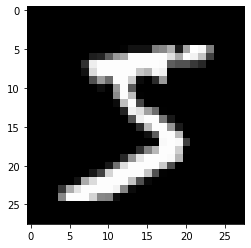

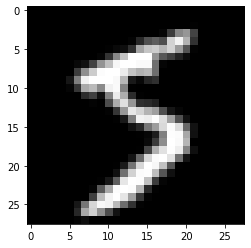

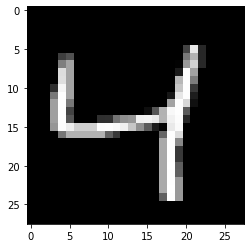

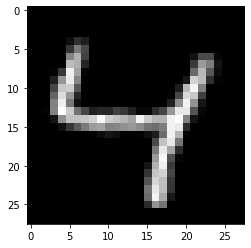

In [308]:
plt.imshow(mnist_test_X[0,0],cmap='gray')
plt.show()
plt.imshow(mnist_test_X_noisy[0,0],cmap='gray')
plt.show()
plt.imshow(mnist_test_X[2,0],cmap='gray')
plt.show()
plt.imshow(mnist_test_X_noisy[2,0],cmap='gray')
plt.show()

In [309]:
configs=dict()
config = dict()
config['weights_config']=[None,None]
config['freeze_layers']=[False,False]
config['membership_config']=[None,None]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=['F.relu', 'F.relu']
config['learning_rate']=1e-5
config['classes']=10
config['imageDim']=(28,28)
config['test_X']=mnist_test_X_noisy
config['test_y']=mnist_test_y
config['train_y']=mnist_train_y
config['train_X']=mnist_train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='SVHN'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['NOL + NOL'] = config

config = dict()
config['weights_config']=[[('Klein',8,8,3,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,[('Klein',8,8,3,.65)]]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=10
config['imageDim']=(28,28)
config['test_X']=mnist_test_X_noisy
config['test_y']=mnist_test_y
config['train_y']=mnist_train_y
config['train_X']=mnist_train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='CIFAR -> KAGGLE'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['KF + KOL'] = config

config = dict()
config['weights_config']=[[('Circle',3,64,None)],None]
config['freeze_layers']=[True,False]
config['membership_config']=[None,[('Circle',3,64,.35)]]
config['convLayerSpecs']=[(1,64,3),(64,64,3)]
config['pools']=[None,None]
config['activations']=[None, 'F.relu']
config['learning_rate']=1e-5
config['classes']=10
config['imageDim']=(28,28)
config['test_X']=mnist_test_X_noisy
config['test_y']=mnist_test_y
config['train_y']=mnist_train_y
config['train_X']=mnist_train_X
config['batchesPerTest']=20
config['batchSize']=100
config['epochs']=5
config['dataset']='CIFAR -> KAGGLE'
config['loss_function']='nn.MSELoss'
config['device'] = device

configs['CF + COL'] = config

In [310]:
test['Noisy Rotate Test MNIST'] = topnet.run_configs(configs, None)

In [311]:
for name, config in configs.items():
    config['test_X']=mnist_test_X
    config['test_y']=mnist_test_y
    config['train_y']=mnist_train_y
    config['train_X']=mnist_train_X_noisy
    config['batchesPerTest']=50
    config['epochs']=5
    config['learning_rate']=1e-6

In [312]:
test['Noisy Rotate Train MNIST'] = topnet.run_configs(configs, None)

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


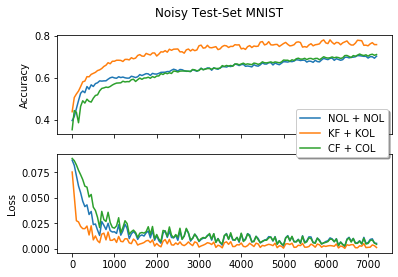

In [315]:
fig, axarr = plt.subplots(2, sharex=True)
fig.set()
fig.suptitle('Noisy Test-Set MNIST')
dataset='Noisy Rotate Test MNIST'
configuration=test[dataset]
for name, item in configuration.items():
    axarr[0].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['accuracies'], label=name)
for name, item in configuration.items():
    axarr[1].plot([i*item['config']['batchesPerTest'] for i in range(len(item['accuracies']))],
             item['loss'])
    
axarr[0].set(ylabel='Accuracy')
axarr[1].set(ylabel='Loss')
fig.legend(loc='center right', shadow=True, bbox_to_anchor=(.91,.5))
fig.set_figheight(4)
fig.set_figwidth(6)
fig.show()

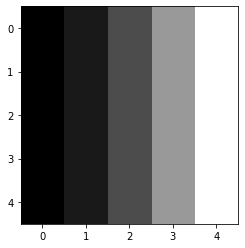

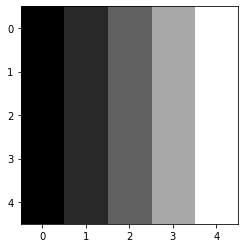

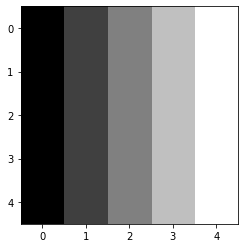

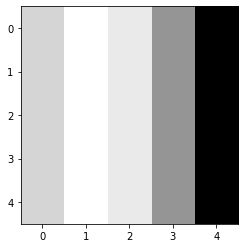

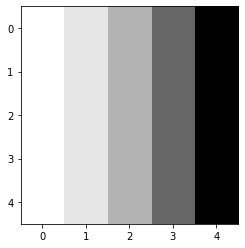

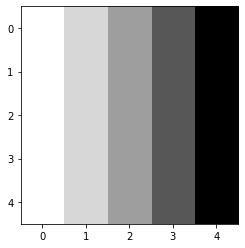

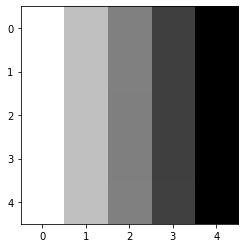

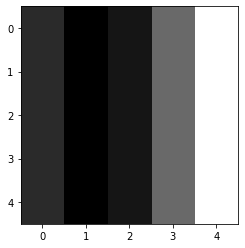

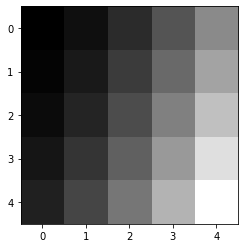

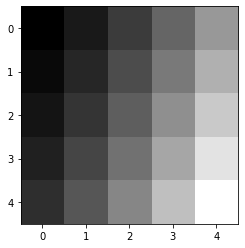

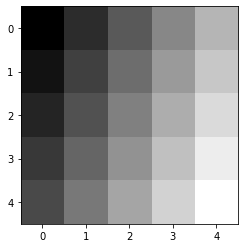

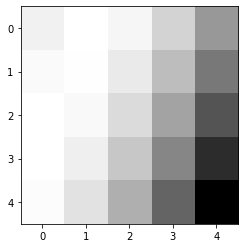

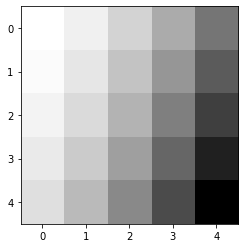

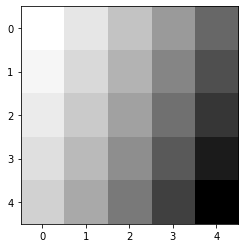

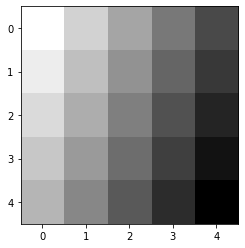

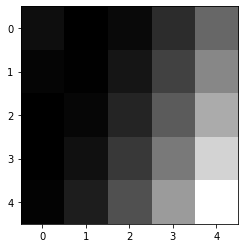

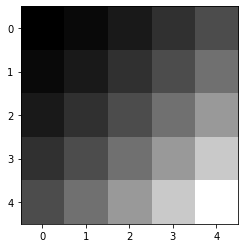

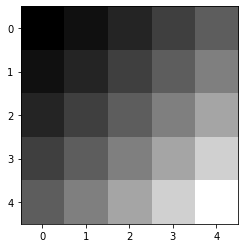

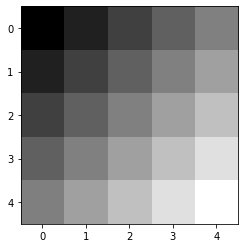

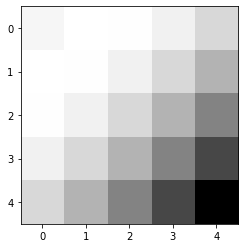

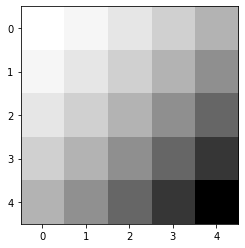

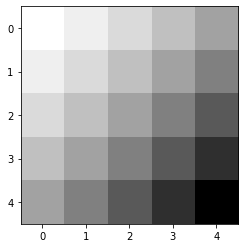

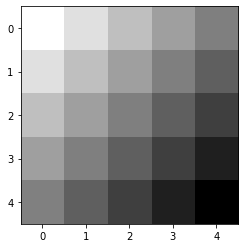

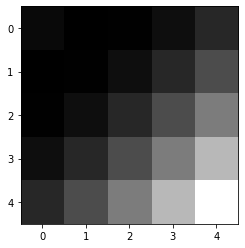

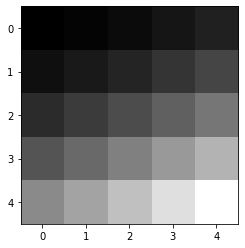

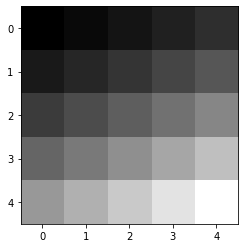

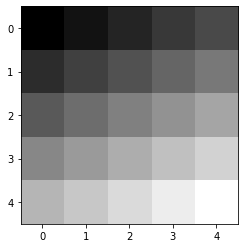

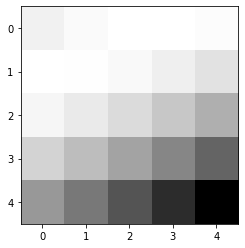

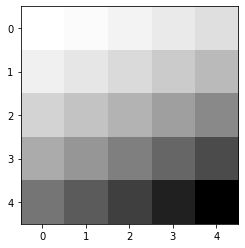

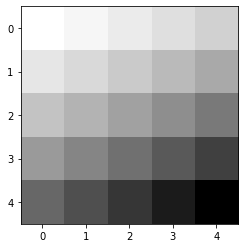

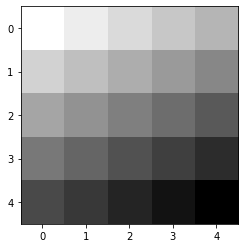

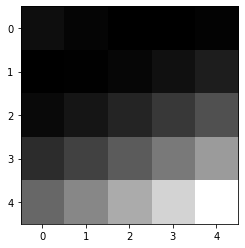

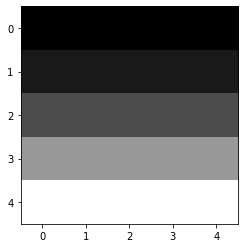

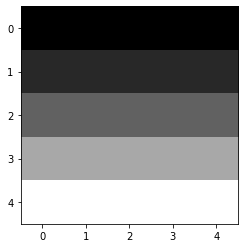

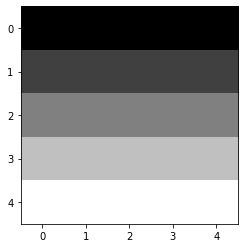

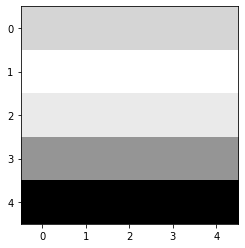

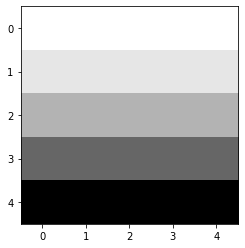

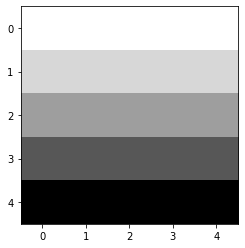

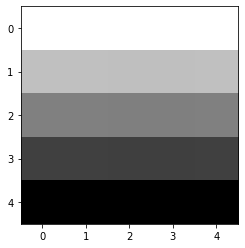

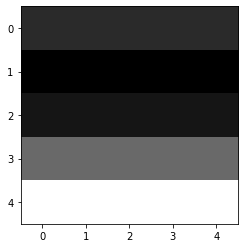

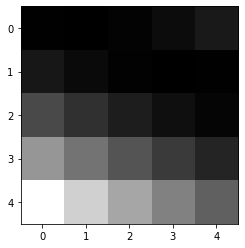

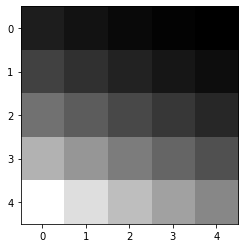

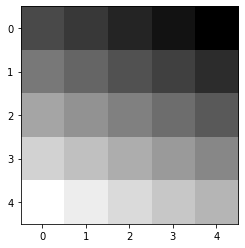

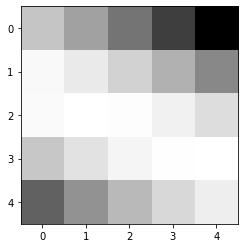

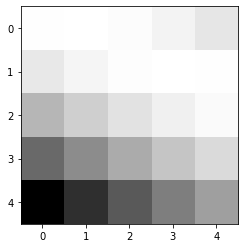

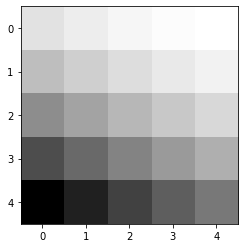

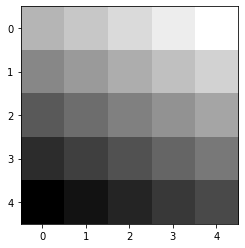

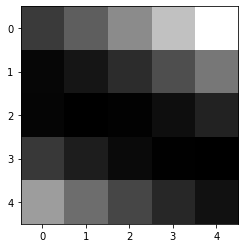

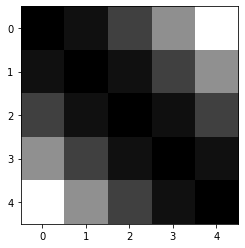

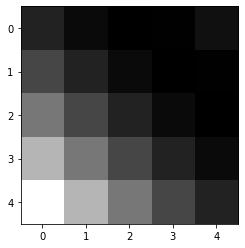

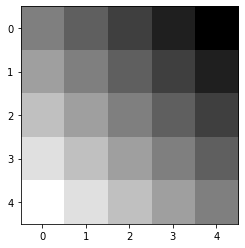

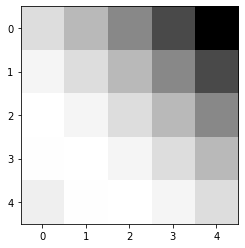

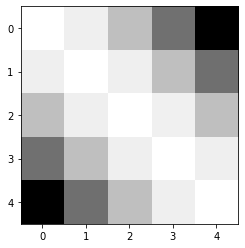

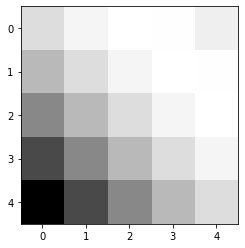

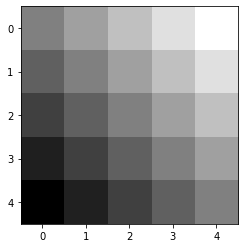

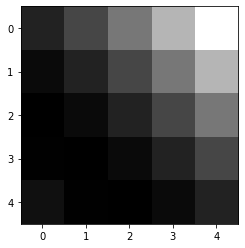

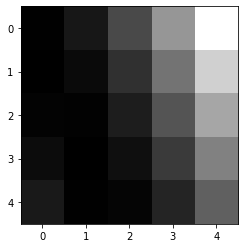

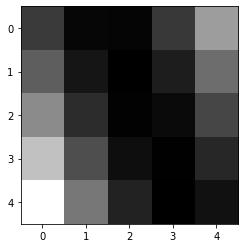

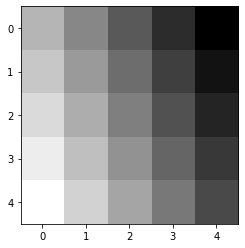

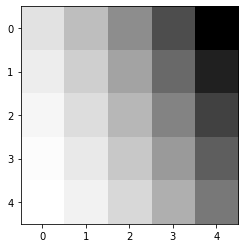

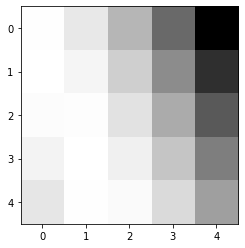

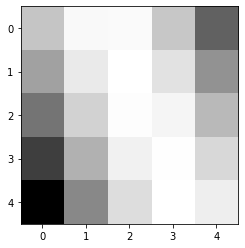

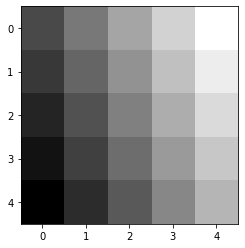

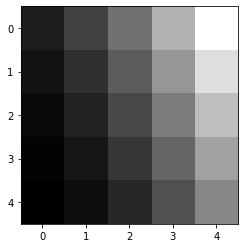

In [30]:
g=topnet.legendre_klein_bottle(8,8,5,None)
for grid in g:
    plt.imshow(grid, cmap='gray')
    plt.show()